# Import Libraries

In [1]:
import numpy as np
import pandas as pd

# Loading the Data and Selecting the Features

### Import Data

In [2]:
loan_data_inputs_train = pd.read_csv('../Data/loan_data_inputs_train.csv', index_col = 0)
loan_data_targets_train = pd.read_csv('../Data/loan_data_targets_train.csv', index_col = 0)
loan_data_inputs_test = pd.read_csv('../Data/loan_data_inputs_test.csv', index_col = 0)
loan_data_targets_test = pd.read_csv('../Data/loan_data_targets_test.csv', index_col = 0)

### Explore Data

In [3]:
loan_data_inputs_train.head()

,Unnamed: 0.1,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,dti:21.7-22.4,dti:22.4-35,dti:>35,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86
427211,427211,12796369,14818505,24000,24000,24000.0,36 months,8.90,762.08,A,...,1,0,0,1,0,0,0,0,0,0
206088,206088,1439740,1691948,10000,10000,10000.0,36 months,14.33,343.39,C,...,0,0,0,1,0,0,0,0,0,0
136020,136020,5214749,6556909,20425,20425,20425.0,36 months,8.90,648.56,A,...,0,0,0,1,0,0,0,0,0,0
412305,412305,13827698,15890016,17200,17200,17200.0,36 months,16.59,609.73,D,...,0,0,0,1,0,0,0,0,0,0
36159,36159,422455,496525,8400,8400,7450.0,36 months,12.84,282.40,C,...,0,1,0,1,0,0,0,0,0,0


In [4]:
loan_data_targets_train.head()

,good_bad
427211,1
206088,1
136020,1
412305,0
36159,0


In [5]:
loan_data_inputs_train.shape

(373028, 324)

In [6]:
loan_data_targets_train.shape

(373028, 1)

In [7]:
loan_data_inputs_test.shape

(93257, 324)

In [8]:
loan_data_targets_test.shape

(93257, 1)

### Selecting the Features

In [9]:
# Here we select a limited set of input variables in a new dataframe.
inputs_train_with_ref_cat = loan_data_inputs_train.loc[: , ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'home_ownership:OWN',
'home_ownership:MORTGAGE',
'addr_state:ND_NE_IA_NV_FL_HI_AL',
'addr_state:NM_VA',
'addr_state:NY',
'addr_state:OK_TN_MO_LA_MD_NC',
'addr_state:CA',
'addr_state:UT_KY_AZ_NJ',
'addr_state:AR_MI_PA_OH_MN',
'addr_state:RI_MA_DE_SD_IN',
'addr_state:GA_WA_OR',
'addr_state:WI_MT',
'addr_state:TX',
'addr_state:IL_CT',
'addr_state:KS_SC_CO_VT_AK_MS',
'addr_state:WV_NH_WY_DC_ME_ID',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:oth__med__vacation',
'purpose:major_purch__car__home_impr',
'initial_list_status:f',
'initial_list_status:w',
'term:36',
'term:60',
'emp_length:0',
'emp_length:1',
'emp_length:2-4',
'emp_length:5-6',
'emp_length:7-9',
'emp_length:10',
'mths_since_issue_d:<38',
'mths_since_issue_d:38-39',
'mths_since_issue_d:40-41',
'mths_since_issue_d:42-48',
'mths_since_issue_d:49-52',
'mths_since_issue_d:53-64',
'mths_since_issue_d:65-84',
'mths_since_issue_d:>84',
'int_rate:<9.548',
'int_rate:9.548-12.025',
'int_rate:12.025-15.74',
'int_rate:15.74-20.281',
'int_rate:>20.281',
'mths_since_earliest_cr_line:<140',
'mths_since_earliest_cr_line:141-164',
'mths_since_earliest_cr_line:165-247',
'mths_since_earliest_cr_line:248-270',
'mths_since_earliest_cr_line:271-352',
'mths_since_earliest_cr_line:>352',
'delinq_2yrs:0',
'delinq_2yrs:1-3',
'delinq_2yrs:>=4',
'inq_last_6mths:0',
'inq_last_6mths:1-2',
'inq_last_6mths:3-6',
'inq_last_6mths:>6',
'open_acc:0',
'open_acc:1-3',
'open_acc:4-12',
'open_acc:13-17',
'open_acc:18-22',
'open_acc:23-25',
'open_acc:26-30',
'open_acc:>=31',
'pub_rec:0-2',
'pub_rec:3-4',
'pub_rec:>=5',
'total_acc:<=27',
'total_acc:28-51',
'total_acc:>=52',
'acc_now_delinq:0',
'acc_now_delinq:>=1',
'total_rev_hi_lim:<=5K',
'total_rev_hi_lim:5K-10K',
'total_rev_hi_lim:10K-20K',
'total_rev_hi_lim:20K-30K',
'total_rev_hi_lim:30K-40K',
'total_rev_hi_lim:40K-55K',
'total_rev_hi_lim:55K-95K',
'total_rev_hi_lim:>95K',
'annual_inc:<20K',
'annual_inc:20K-30K',
'annual_inc:30K-40K',
'annual_inc:40K-50K',
'annual_inc:50K-60K',
'annual_inc:60K-70K',
'annual_inc:70K-80K',
'annual_inc:80K-90K',
'annual_inc:90K-100K',
'annual_inc:100K-120K',
'annual_inc:120K-140K',
'annual_inc:>140K',
'dti:<=1.4',
'dti:1.4-3.5',
'dti:3.5-7.7',
'dti:7.7-10.5',
'dti:10.5-16.1',
'dti:16.1-20.3',
'dti:20.3-21.7',
'dti:21.7-22.4',
'dti:22.4-35',
'dti:>35',
'mths_since_last_delinq:Missing',
'mths_since_last_delinq:0-3',
'mths_since_last_delinq:4-30',
'mths_since_last_delinq:31-56',
'mths_since_last_delinq:>=57',
'mths_since_last_record:Missing',
'mths_since_last_record:0-2',
'mths_since_last_record:3-20',
'mths_since_last_record:21-31',
'mths_since_last_record:32-80',
'mths_since_last_record:81-86',
'mths_since_last_record:>86',
]]

In [10]:
# Here we store the names of the reference category dummy variables in a list.
ref_categories = ['grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'addr_state:ND_NE_IA_NV_FL_HI_AL',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'initial_list_status:f',
'term:60',
'emp_length:0',
'mths_since_issue_d:>84',
'int_rate:>20.281',
'mths_since_earliest_cr_line:<140',
'delinq_2yrs:>=4',
'inq_last_6mths:>6',
'open_acc:0',
'pub_rec:0-2',
'total_acc:<=27',
'acc_now_delinq:0',
'total_rev_hi_lim:<=5K',
'annual_inc:<20K',
'dti:>35',
'mths_since_last_delinq:0-3',
'mths_since_last_record:0-2']

In [11]:
inputs_train = inputs_train_with_ref_cat.drop(ref_categories, axis = 1)
# From the dataframe with input variables, we drop the variables with variable names in the list with reference categories. 
inputs_train.head()

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:NM_VA,addr_state:NY,...,mths_since_last_delinq:Missing,mths_since_last_delinq:4-30,mths_since_last_delinq:31-56,mths_since_last_delinq:>=57,mths_since_last_record:Missing,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86
427211,1,0,0,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
206088,0,0,1,0,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,0,0
136020,1,0,0,0,0,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
412305,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
36159,0,0,1,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0


# PD Model Estimation

## Logistic Regression

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [13]:
reg = LogisticRegression()
# We create an instance of an object from the 'LogisticRegression' class.

In [14]:
pd.options.display.max_rows = None
# Sets the pandas dataframe options to display all columns/ rows.

In [15]:
inputs_train.shape

(373028, 104)

In [16]:
loan_data_targets_train.shape

(373028, 1)

In [17]:
reg.fit(inputs_train, loan_data_targets_train)
# Estimates the coefficients of the object from the 'LogisticRegression' class
# with inputs (independent variables) contained in the first dataframe
# and targets (dependent variables) contained in the second dataframe.

C:\Users\sidhu\AppData\Local\Continuum\anaconda3\envs\PythonCPU\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sidhu\AppData\Local\Continuum\anaconda3\envs\PythonCPU\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [18]:
reg.intercept_
# Displays the intercept contain in the estimated ("fitted") object from the 'LogisticRegression' class.

array([-1.33112694])

In [19]:
reg.coef_
# Displays the coefficients contained in the estimated ("fitted") object from the 'LogisticRegression' class.

array([[ 1.16011082,  0.90606204,  0.7088689 ,  0.51906409,  0.33683631,
         0.14490381,  0.09080402,  0.1067844 ,  0.02966993,  0.05523954,
         0.05659918,  0.05939865,  0.07496436,  0.13243716,  0.0993491 ,
         0.18111793,  0.22492877,  0.2203393 ,  0.2591459 ,  0.31661628,
         0.51751281,  0.08806499, -0.01075775,  0.30677429,  0.20251449,
         0.21415047,  0.26666514,  0.05442893,  0.07807138,  0.10017279,
         0.12529414,  0.08959227,  0.06084373,  0.12334399,  1.07505946,
         0.8743565 ,  0.77403155,  0.57294395,  0.41065224,  0.1658744 ,
        -0.06981823,  0.8505458 ,  0.53834264,  0.28958786,  0.10064557,
         0.05611369,  0.03782336,  0.07954707,  0.1195392 ,  0.12624275,
         0.07426824,  0.03130012,  0.63481087,  0.49141354,  0.28204165,
        -0.0110308 , -0.10865466, -0.13433101, -0.1497351 , -0.15434083,
        -0.11933904, -0.20971706,  0.12264264,  0.17844105, -0.02093621,
         0.02534292,  0.21759116,  0.03469447,  0.0

In [20]:
feature_name = inputs_train.columns.values
# Stores the names of the columns of a dataframe in a variable.

In [21]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
# Creates a dataframe with a column titled 'Feature name' and row values contained in the 'feature_name' variable.
summary_table['Coefficients'] = np.transpose(reg.coef_)
# Creates a new column in the dataframe, called 'Coefficients',
# with row values the transposed coefficients from the 'LogisticRegression' object.
summary_table.index = summary_table.index + 1
# Increases the index of every row of the dataframe with 1.
summary_table.loc[0] = ['Intercept', reg.intercept_[0]]
# Assigns values of the row with index 0 of the dataframe.
summary_table = summary_table.sort_index()
# Sorts the dataframe by index.
summary_table

,Feature name,Coefficients
0,Intercept,-1.331127
1,grade:A,1.160111
2,grade:B,0.906062
3,grade:C,0.708869
4,grade:D,0.519064
5,grade:E,0.336836
6,grade:F,0.144904
7,home_ownership:OWN,0.090804
8,home_ownership:MORTGAGE,0.106784
9,addr_state:NM_VA,0.029670


## Build a Logistic Regression Model with P-Values

In [22]:
# P values for sklearn logistic regression.

# Class to display p-values for logistic regression in sklearn.

from sklearn import linear_model
import scipy.stats as stat

class LogisticRegression_with_p_values:
    
    def __init__(self,*args,**kwargs):#,**kwargs):
        self.model = linear_model.LogisticRegression(*args,**kwargs)#,**args)

    def fit(self,X,y):
        self.model.fit(X,y)
        
        #### Get p-values for the fitted model ####
        denom = (2.0 * (1.0 + np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X / denom).T,X) ## Fisher Information Matrix
        Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0] / sigma_estimates # z-score for eaach model coefficient
        p_values = [stat.norm.sf(abs(x)) * 2 for x in z_scores] ### two tailed test for p-values
        
        self.coef_ = self.model.coef_
        self.intercept_ = self.model.intercept_
        #self.z_scores = z_scores
        self.p_values = p_values
        #self.sigma_estimates = sigma_estimates
        #self.F_ij = F_ij

In [23]:
from sklearn import linear_model
import scipy.stats as stat

class LogisticRegression_with_p_values:
    
    def __init__(self,*args,**kwargs):
        self.model = linear_model.LogisticRegression(*args,**kwargs)

    def fit(self,X,y):
        self.model.fit(X,y)
        denom = (2.0 * (1.0 + np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X / denom).T,X)
        Cramer_Rao = np.linalg.inv(F_ij)
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0] / sigma_estimates
        p_values = [stat.norm.sf(abs(x)) * 2 for x in z_scores]
        self.coef_ = self.model.coef_
        self.intercept_ = self.model.intercept_
        self.p_values = p_values

In [24]:
reg = LogisticRegression_with_p_values()
# We create an instance of an object from the newly created 'LogisticRegression_with_p_values()' class.

In [25]:
reg.fit(inputs_train, loan_data_targets_train)
# Estimates the coefficients of the object from the 'LogisticRegression' class
# with inputs (independent variables) contained in the first dataframe
# and targets (dependent variables) contained in the second dataframe.

C:\Users\sidhu\AppData\Local\Continuum\anaconda3\envs\PythonCPU\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sidhu\AppData\Local\Continuum\anaconda3\envs\PythonCPU\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [26]:
# Same as above.
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg.intercept_[0]]
summary_table = summary_table.sort_index()
summary_table

,Feature name,Coefficients
0,Intercept,-1.331127
1,grade:A,1.160111
2,grade:B,0.906062
3,grade:C,0.708869
4,grade:D,0.519064
5,grade:E,0.336836
6,grade:F,0.144904
7,home_ownership:OWN,0.090804
8,home_ownership:MORTGAGE,0.106784
9,addr_state:NM_VA,0.029670


In [27]:
# This is a list.
p_values = reg.p_values
# We take the result of the newly added method 'p_values' and store it in a variable 'p_values'.

In [28]:
# Add the intercept for completeness.
p_values = np.append(np.nan, np.array(p_values))
# We add the value 'NaN' in the beginning of the variable with p-values.

In [29]:
summary_table['p_values'] = p_values
# In the 'summary_table' dataframe, we add a new column, called 'p_values', containing the values from the 'p_values' variable.

In [30]:
summary_table

,Feature name,Coefficients,p_values
0,Intercept,-1.331127,NaN
1,grade:A,1.160111,1.701206e-37
2,grade:B,0.906062,1.037505e-49
3,grade:C,0.708869,6.538477e-36
4,grade:D,0.519064,4.993963e-22
5,grade:E,0.336836,2.510850e-12
6,grade:F,0.144904,3.857081e-03
7,home_ownership:OWN,0.090804,6.797437e-06
8,home_ownership:MORTGAGE,0.106784,4.239183e-17
9,addr_state:NM_VA,0.029670,3.545567e-01


In [31]:
# We are going to remove some features, the coefficients for all or almost all of the dummy variables for which,
# are not tatistically significant.

# We do that by specifying another list of dummy variables as reference categories, and a list of variables to remove.
# Then, we are going to drop the two datasets from the original list of dummy variables.

# Variables
inputs_train_with_ref_cat = loan_data_inputs_train.loc[: , ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'home_ownership:OWN',
'home_ownership:MORTGAGE',
'addr_state:ND_NE_IA_NV_FL_HI_AL',
'addr_state:NM_VA',
'addr_state:NY',
'addr_state:OK_TN_MO_LA_MD_NC',
'addr_state:CA',
'addr_state:UT_KY_AZ_NJ',
'addr_state:AR_MI_PA_OH_MN',
'addr_state:RI_MA_DE_SD_IN',
'addr_state:GA_WA_OR',
'addr_state:WI_MT',
'addr_state:TX',
'addr_state:IL_CT',
'addr_state:KS_SC_CO_VT_AK_MS',
'addr_state:WV_NH_WY_DC_ME_ID',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:oth__med__vacation',
'purpose:major_purch__car__home_impr',
'initial_list_status:f',
'initial_list_status:w',
'term:36',
'term:60',
'emp_length:0',
'emp_length:1',
'emp_length:2-4',
'emp_length:5-6',
'emp_length:7-9',
'emp_length:10',
'mths_since_issue_d:<38',
'mths_since_issue_d:38-39',
'mths_since_issue_d:40-41',
'mths_since_issue_d:42-48',
'mths_since_issue_d:49-52',
'mths_since_issue_d:53-64',
'mths_since_issue_d:65-84',
'mths_since_issue_d:>84',
'int_rate:<9.548',
'int_rate:9.548-12.025',
'int_rate:12.025-15.74',
'int_rate:15.74-20.281',
'int_rate:>20.281',
'mths_since_earliest_cr_line:<140',
'mths_since_earliest_cr_line:141-164',
'mths_since_earliest_cr_line:165-247',
'mths_since_earliest_cr_line:248-270',
'mths_since_earliest_cr_line:271-352',
'mths_since_earliest_cr_line:>352',
'inq_last_6mths:0',
'inq_last_6mths:1-2',
'inq_last_6mths:3-6',
'inq_last_6mths:>6',
'acc_now_delinq:0',
'acc_now_delinq:>=1',
'annual_inc:<20K',
'annual_inc:20K-30K',
'annual_inc:30K-40K',
'annual_inc:40K-50K',
'annual_inc:50K-60K',
'annual_inc:60K-70K',
'annual_inc:70K-80K',
'annual_inc:80K-90K',
'annual_inc:90K-100K',
'annual_inc:100K-120K',
'annual_inc:120K-140K',
'annual_inc:>140K',
'dti:<=1.4',
'dti:1.4-3.5',
'dti:3.5-7.7',
'dti:7.7-10.5',
'dti:10.5-16.1',
'dti:16.1-20.3',
'dti:20.3-21.7',
'dti:21.7-22.4',
'dti:22.4-35',
'dti:>35',
'mths_since_last_delinq:Missing',
'mths_since_last_delinq:0-3',
'mths_since_last_delinq:4-30',
'mths_since_last_delinq:31-56',
'mths_since_last_delinq:>=57',
'mths_since_last_record:Missing',
'mths_since_last_record:0-2',
'mths_since_last_record:3-20',
'mths_since_last_record:21-31',
'mths_since_last_record:32-80',
'mths_since_last_record:81-86',
'mths_since_last_record:>86',
]]

ref_categories = ['grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'addr_state:ND_NE_IA_NV_FL_HI_AL',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'initial_list_status:f',
'term:60',
'emp_length:0',
'mths_since_issue_d:>84',
'int_rate:>20.281',
'mths_since_earliest_cr_line:<140',
'inq_last_6mths:>6',
'acc_now_delinq:0',
'annual_inc:<20K',
'dti:>35',
'mths_since_last_delinq:0-3',
'mths_since_last_record:0-2']

In [32]:
inputs_train = inputs_train_with_ref_cat.drop(ref_categories, axis = 1)
inputs_train.head()

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:NM_VA,addr_state:NY,...,mths_since_last_delinq:Missing,mths_since_last_delinq:4-30,mths_since_last_delinq:31-56,mths_since_last_delinq:>=57,mths_since_last_record:Missing,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86
427211,1,0,0,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
206088,0,0,1,0,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,0,0
136020,1,0,0,0,0,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
412305,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
36159,0,0,1,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0


In [33]:
# Here we run a new model.
reg2 = LogisticRegression_with_p_values()
reg2.fit(inputs_train, loan_data_targets_train)

C:\Users\sidhu\AppData\Local\Continuum\anaconda3\envs\PythonCPU\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sidhu\AppData\Local\Continuum\anaconda3\envs\PythonCPU\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [34]:
feature_name = inputs_train.columns.values

In [35]:
# Same as above.
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg2.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg2.intercept_[0]]
summary_table = summary_table.sort_index()
summary_table

,Feature name,Coefficients
0,Intercept,-1.374022
1,grade:A,1.123667
2,grade:B,0.878915
3,grade:C,0.684794
4,grade:D,0.496922
5,grade:E,0.321491
6,grade:F,0.134284
7,home_ownership:OWN,0.093517
8,home_ownership:MORTGAGE,0.106248
9,addr_state:NM_VA,0.036018


In [36]:
# We add the 'p_values' here, just as we did before.
p_values = reg2.p_values
p_values = np.append(np.nan,np.array(p_values))
summary_table['p_values'] = p_values
summary_table
# Here we get the results for our final PD model.

,Feature name,Coefficients,p_values
0,Intercept,-1.374022,NaN
1,grade:A,1.123667,3.224492e-35
2,grade:B,0.878915,4.281595e-47
3,grade:C,0.684794,6.716246e-34
4,grade:D,0.496922,1.347121e-20
5,grade:E,0.321491,1.025626e-11
6,grade:F,0.134284,6.241920e-03
7,home_ownership:OWN,0.093517,3.460313e-06
8,home_ownership:MORTGAGE,0.106248,4.424420e-17
9,addr_state:NM_VA,0.036018,2.608636e-01


In [37]:
import pickle

In [38]:
pickle.dump(reg2, open('pd_model.sav', 'wb'))
# Here we export our model to a 'SAV' file with file name 'pd_model.sav'.

# PD Model Validation (Test)

### Out-of-sample validation (test)

In [39]:
# Here, from the dataframe with inputs for testing, we keep the same variables that we used in our final PD model.
inputs_test_with_ref_cat = loan_data_inputs_test.loc[: , ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'home_ownership:OWN',
'home_ownership:MORTGAGE',
'addr_state:ND_NE_IA_NV_FL_HI_AL',
'addr_state:NM_VA',
'addr_state:NY',
'addr_state:OK_TN_MO_LA_MD_NC',
'addr_state:CA',
'addr_state:UT_KY_AZ_NJ',
'addr_state:AR_MI_PA_OH_MN',
'addr_state:RI_MA_DE_SD_IN',
'addr_state:GA_WA_OR',
'addr_state:WI_MT',
'addr_state:TX',
'addr_state:IL_CT',
'addr_state:KS_SC_CO_VT_AK_MS',
'addr_state:WV_NH_WY_DC_ME_ID',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:oth__med__vacation',
'purpose:major_purch__car__home_impr',
'initial_list_status:f',
'initial_list_status:w',
'term:36',
'term:60',
'emp_length:0',
'emp_length:1',
'emp_length:2-4',
'emp_length:5-6',
'emp_length:7-9',
'emp_length:10',
'mths_since_issue_d:<38',
'mths_since_issue_d:38-39',
'mths_since_issue_d:40-41',
'mths_since_issue_d:42-48',
'mths_since_issue_d:49-52',
'mths_since_issue_d:53-64',
'mths_since_issue_d:65-84',
'mths_since_issue_d:>84',
'int_rate:<9.548',
'int_rate:9.548-12.025',
'int_rate:12.025-15.74',
'int_rate:15.74-20.281',
'int_rate:>20.281',
'mths_since_earliest_cr_line:<140',
'mths_since_earliest_cr_line:141-164',
'mths_since_earliest_cr_line:165-247',
'mths_since_earliest_cr_line:248-270',
'mths_since_earliest_cr_line:271-352',
'mths_since_earliest_cr_line:>352',
'inq_last_6mths:0',
'inq_last_6mths:1-2',
'inq_last_6mths:3-6',
'inq_last_6mths:>6',
'acc_now_delinq:0',
'acc_now_delinq:>=1',
'annual_inc:<20K',
'annual_inc:20K-30K',
'annual_inc:30K-40K',
'annual_inc:40K-50K',
'annual_inc:50K-60K',
'annual_inc:60K-70K',
'annual_inc:70K-80K',
'annual_inc:80K-90K',
'annual_inc:90K-100K',
'annual_inc:100K-120K',
'annual_inc:120K-140K',
'annual_inc:>140K',
'dti:<=1.4',
'dti:1.4-3.5',
'dti:3.5-7.7',
'dti:7.7-10.5',
'dti:10.5-16.1',
'dti:16.1-20.3',
'dti:20.3-21.7',
'dti:21.7-22.4',
'dti:22.4-35',
'dti:>35',
'mths_since_last_delinq:Missing',
'mths_since_last_delinq:0-3',
'mths_since_last_delinq:4-30',
'mths_since_last_delinq:31-56',
'mths_since_last_delinq:>=57',
'mths_since_last_record:Missing',
'mths_since_last_record:0-2',
'mths_since_last_record:3-20',
'mths_since_last_record:21-31',
'mths_since_last_record:32-80',
'mths_since_last_record:81-86',
'mths_since_last_record:>86',
]]

In [40]:
# And here, in the list below, we keep the variable names for the reference categories,
# only for the variables we used in our final PD model.
ref_categories = ['grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'addr_state:ND_NE_IA_NV_FL_HI_AL',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'initial_list_status:f',
'term:60',
'emp_length:0',
'mths_since_issue_d:>84',
'int_rate:>20.281',
'mths_since_earliest_cr_line:<140',
'inq_last_6mths:>6',
'acc_now_delinq:0',
'annual_inc:<20K',
'dti:>35',
'mths_since_last_delinq:0-3',
'mths_since_last_record:0-2']

In [41]:
inputs_test = inputs_test_with_ref_cat.drop(ref_categories, axis = 1)
inputs_test.head()

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:NM_VA,addr_state:NY,...,mths_since_last_delinq:Missing,mths_since_last_delinq:4-30,mths_since_last_delinq:31-56,mths_since_last_delinq:>=57,mths_since_last_record:Missing,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86
362514,0,0,1,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
288564,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
213591,0,0,1,0,0,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
263083,0,0,1,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
165001,1,0,0,0,0,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0


In [42]:
y_hat_test = reg2.model.predict(inputs_test)
# Calculates the predicted values for the dependent variable (targets)
# based on the values of the independent variables (inputs) supplied as an argument.

In [43]:
y_hat_test
# This is an array of predicted discrete classess (in this case, 0s and 1s).

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [44]:
y_hat_test_proba = reg2.model.predict_proba(inputs_test)
# Calculates the predicted probability values for the dependent variable (targets)
# based on the values of the independent variables (inputs) supplied as an argument.

In [45]:
y_hat_test_proba
# This is an array of arrays of predicted class probabilities for all classes.
# In this case, the first value of every sub-array is the probability for the observation to belong to the first class, i.e. 0,
# and the second value is the probability for the observation to belong to the first class, i.e. 1.

array([[0.07569442, 0.92430558],
       [0.15076115, 0.84923885],
       [0.11465125, 0.88534875],
       ...,
       [0.02678664, 0.97321336],
       [0.04020868, 0.95979132],
       [0.04763351, 0.95236649]])

In [46]:
y_hat_test_proba[:][:,1]
# Here we take all the arrays in the array, and from each array, we take all rows, and only the element with index 1,
# that is, the second element.
# In other words, we take only the probabilities for being 1.

array([0.92430558, 0.84923885, 0.88534875, ..., 0.97321336, 0.95979132,
       0.95236649])

In [47]:
y_hat_test_proba = y_hat_test_proba[: ][: , 1]
# We store these probabilities in a variable.

In [48]:
y_hat_test_proba
# This variable contains an array of probabilities of being 1.

array([0.92430558, 0.84923885, 0.88534875, ..., 0.97321336, 0.95979132,
       0.95236649])

In [49]:
loan_data_targets_test_temp = loan_data_targets_test

In [50]:
loan_data_targets_test_temp.reset_index(drop = True, inplace = True)
# We reset the index of a dataframe.

In [51]:
df_actual_predicted_probs = pd.concat([loan_data_targets_test_temp, pd.DataFrame(y_hat_test_proba)], axis = 1)
# Concatenates two dataframes.

In [52]:
df_actual_predicted_probs.shape

(93257, 2)

In [53]:
df_actual_predicted_probs.columns = ['loan_data_targets_test', 'y_hat_test_proba']

In [54]:
df_actual_predicted_probs.index = loan_data_inputs_test.index
# Makes the index of one dataframe equal to the index of another dataframe.

In [55]:
df_actual_predicted_probs.head()

,loan_data_targets_test,y_hat_test_proba
362514,1,0.924306
288564,1,0.849239
213591,1,0.885349
263083,1,0.940636
165001,1,0.968665


### Accuracy and Area under the Curve

In [56]:
tr = 0.9
# We create a new column with an indicator,
# where every observation that has predicted probability greater than the threshold has a value of 1,
# and every observation that has predicted probability lower than the threshold has a value of 0.
df_actual_predicted_probs['y_hat_test'] = np.where(df_actual_predicted_probs['y_hat_test_proba'] > tr, 1, 0)

In [57]:
pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'], rownames = ['Actual'], colnames = ['Predicted'])
# Creates a cross-table where the actual values are displayed by rows and the predicted values by columns.
# This table is known as a Confusion Matrix.

Predicted,0,1
Actual,,
0,7374,2816
1,35813,47254


In [58]:
pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'], rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]
# Here we divide each value of the table by the total number of observations,
# thus getting percentages, or, rates.

Predicted,0,1
Actual,,
0,0.079072,0.030196
1,0.384025,0.506707


In [59]:
(pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'], rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]).iloc[0, 0] + (pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'], rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]).iloc[1, 1]
# Here we calculate Accuracy of the model, which is the sum of the diagonal rates.

0.5857790836076648

In [60]:
from sklearn.metrics import roc_curve, roc_auc_score

In [61]:
roc_curve(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test_proba'])
# Returns the Receiver Operating Characteristic (ROC) Curve from a set of actual values and their predicted probabilities.
# As a result, we get three arrays: the false positive rates, the true positive rates, and the thresholds.

(array([0.        , 0.        , 0.        , ..., 0.99960746, 1.        ,
        1.        ]),
 array([0.00000000e+00, 1.20384750e-05, 1.20384750e-04, ...,
        9.99975923e-01, 9.99975923e-01, 1.00000000e+00]),
 array([1.99262865, 0.99262865, 0.99069771, ..., 0.48790773, 0.3937389 ,
        0.37528625]))

In [62]:
fpr, tpr, thresholds = roc_curve(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test_proba'])
# Here we store each of the three arrays in a separate variable. 

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Text(0.5, 1.0, 'ROC curve')

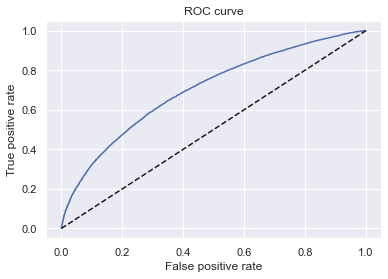

In [64]:
plt.plot(fpr, tpr)
# We plot the false positive rate along the x-axis and the true positive rate along the y-axis,
# thus plotting the ROC curve.
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
# We plot a seconary diagonal line, with dashed line style and black color.
plt.xlabel('False positive rate')
# We name the x-axis "False positive rate".
plt.ylabel('True positive rate')
# We name the x-axis "True positive rate".
plt.title('ROC curve')
# We name the graph "ROC curve".

In [65]:
AUROC = roc_auc_score(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test_proba'])
# Calculates the Area Under the Receiver Operating Characteristic Curve (AUROC)
# from a set of actual values and their predicted probabilities.
AUROC

0.7022081357100709

### Gini and Kolmogorov-Smirnov

In [66]:
df_actual_predicted_probs = df_actual_predicted_probs.sort_values('y_hat_test_proba')
# Sorts a dataframe by the values of a specific column.

In [67]:
df_actual_predicted_probs.head()

,loan_data_targets_test,y_hat_test_proba,y_hat_test
42341,1,0.375286,0
42344,1,0.392102,0
39810,0,0.393739,0
40518,0,0.448969,0
42396,0,0.457735,0


In [68]:
df_actual_predicted_probs.tail()

,loan_data_targets_test,y_hat_test_proba,y_hat_test
262480,1,0.991292,1
231463,1,0.991304,1
239228,1,0.991652,1
261086,1,0.992058,1
242624,1,0.992629,1


In [69]:
df_actual_predicted_probs = df_actual_predicted_probs.reset_index()
# We reset the index of a dataframe and overwrite it.

In [70]:
df_actual_predicted_probs.head()

,index,loan_data_targets_test,y_hat_test_proba,y_hat_test
0,42341,1,0.375286,0
1,42344,1,0.392102,0
2,39810,0,0.393739,0
3,40518,0,0.448969,0
4,42396,0,0.457735,0


In [71]:
df_actual_predicted_probs['Cumulative N Population'] = df_actual_predicted_probs.index + 1
# We calculate the cumulative number of all observations.
# We use the new index for that. Since indexing in ython starts from 0, we add 1 to each index.
df_actual_predicted_probs['Cumulative N Good'] = df_actual_predicted_probs['loan_data_targets_test'].cumsum()
# We calculate cumulative number of 'good', which is the cumulative sum of the column with actual observations.
df_actual_predicted_probs['Cumulative N Bad'] = df_actual_predicted_probs['Cumulative N Population'] - df_actual_predicted_probs['loan_data_targets_test'].cumsum()
# We calculate cumulative number of 'bad', which is
# the difference between the cumulative number of all observations and cumulative number of 'good' for each row.

In [72]:
df_actual_predicted_probs.head()

,index,loan_data_targets_test,y_hat_test_proba,y_hat_test,Cumulative N Population,Cumulative N Good,Cumulative N Bad
0,42341,1,0.375286,0,1,1,0
1,42344,1,0.392102,0,2,2,0
2,39810,0,0.393739,0,3,2,1
3,40518,0,0.448969,0,4,2,2
4,42396,0,0.457735,0,5,2,3


In [73]:
df_actual_predicted_probs['Cumulative Perc Population'] = df_actual_predicted_probs['Cumulative N Population'] / (df_actual_predicted_probs.shape[0])
# We calculate the cumulative percentage of all observations.
df_actual_predicted_probs['Cumulative Perc Good'] = df_actual_predicted_probs['Cumulative N Good'] / df_actual_predicted_probs['loan_data_targets_test'].sum()
# We calculate cumulative percentage of 'good'.
df_actual_predicted_probs['Cumulative Perc Bad'] = df_actual_predicted_probs['Cumulative N Bad'] / (df_actual_predicted_probs.shape[0] - df_actual_predicted_probs['loan_data_targets_test'].sum())
# We calculate the cumulative percentage of 'bad'.

In [74]:
df_actual_predicted_probs.head()

,index,loan_data_targets_test,y_hat_test_proba,y_hat_test,Cumulative N Population,Cumulative N Good,Cumulative N Bad,Cumulative Perc Population,Cumulative Perc Good,Cumulative Perc Bad
0,42341,1,0.375286,0,1,1,0,0.000011,0.000012,0.000000
1,42344,1,0.392102,0,2,2,0,0.000021,0.000024,0.000000
2,39810,0,0.393739,0,3,2,1,0.000032,0.000024,0.000098
3,40518,0,0.448969,0,4,2,2,0.000043,0.000024,0.000196
4,42396,0,0.457735,0,5,2,3,0.000054,0.000024,0.000294


In [75]:
df_actual_predicted_probs.tail()

,index,loan_data_targets_test,y_hat_test_proba,y_hat_test,Cumulative N Population,Cumulative N Good,Cumulative N Bad,Cumulative Perc Population,Cumulative Perc Good,Cumulative Perc Bad
93252,262480,1,0.991292,1,93253,83063,10190,0.999957,0.999952,1.0
93253,231463,1,0.991304,1,93254,83064,10190,0.999968,0.999964,1.0
93254,239228,1,0.991652,1,93255,83065,10190,0.999979,0.999976,1.0
93255,261086,1,0.992058,1,93256,83066,10190,0.999989,0.999988,1.0
93256,242624,1,0.992629,1,93257,83067,10190,1.000000,1.000000,1.0


Text(0.5, 1.0, 'Gini')

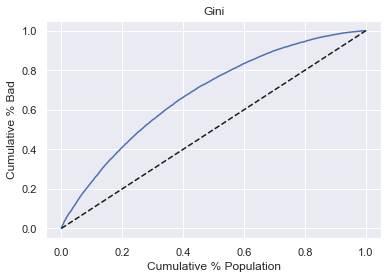

In [76]:
# Plot Gini
plt.plot(df_actual_predicted_probs['Cumulative Perc Population'], df_actual_predicted_probs['Cumulative Perc Bad'])
# We plot the cumulative percentage of all along the x-axis and the cumulative percentage 'good' along the y-axis,
# thus plotting the Gini curve.
plt.plot(df_actual_predicted_probs['Cumulative Perc Population'], df_actual_predicted_probs['Cumulative Perc Population'], linestyle = '--', color = 'k')
# We plot a seconary diagonal line, with dashed line style and black color.
plt.xlabel('Cumulative % Population')
# We name the x-axis "Cumulative % Population".
plt.ylabel('Cumulative % Bad')
# We name the y-axis "Cumulative % Bad".
plt.title('Gini')
# We name the graph "Gini".

In [77]:
Gini = AUROC * 2 - 1
# Here we calculate Gini from AUROC.
Gini

0.4044162714201418

Text(0.5, 1.0, 'Kolmogorov-Smirnov')

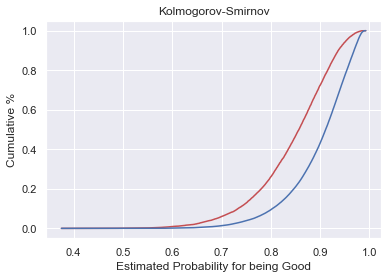

In [78]:
# Plot KS
plt.plot(df_actual_predicted_probs['y_hat_test_proba'], df_actual_predicted_probs['Cumulative Perc Bad'], color = 'r')
# We plot the predicted (estimated) probabilities along the x-axis and the cumulative percentage 'bad' along the y-axis,
# colored in red.
plt.plot(df_actual_predicted_probs['y_hat_test_proba'], df_actual_predicted_probs['Cumulative Perc Good'], color = 'b')
# We plot the predicted (estimated) probabilities along the x-axis and the cumulative percentage 'good' along the y-axis,
# colored in red.
plt.xlabel('Estimated Probability for being Good')
# We name the x-axis "Estimated Probability for being Good".
plt.ylabel('Cumulative %')
# We name the y-axis "Cumulative %".
plt.title('Kolmogorov-Smirnov')
# We name the graph "Kolmogorov-Smirnov".

In [79]:
KS = max(df_actual_predicted_probs['Cumulative Perc Bad'] - df_actual_predicted_probs['Cumulative Perc Good'])
# We calculate KS from the data. It is the maximum of the difference between the cumulative percentage of 'bad'
# and the cumulative percentage of 'good'.
KS

0.2966746932223847

# Applying the PD Model

### Calculating PD of individual accounts

In [80]:
pd.options.display.max_columns = None
# Sets the pandas dataframe options to display all columns/ rows.

In [81]:
inputs_test_with_ref_cat.head()

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:RENT_OTHER_NONE_ANY,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:ND_NE_IA_NV_FL_HI_AL,addr_state:NM_VA,addr_state:NY,addr_state:OK_TN_MO_LA_MD_NC,addr_state:CA,addr_state:UT_KY_AZ_NJ,addr_state:AR_MI_PA_OH_MN,addr_state:RI_MA_DE_SD_IN,addr_state:GA_WA_OR,addr_state:WI_MT,addr_state:TX,addr_state:IL_CT,addr_state:KS_SC_CO_VT_AK_MS,addr_state:WV_NH_WY_DC_ME_ID,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,purpose:educ__sm_b__wedd__ren_en__mov__house,purpose:credit_card,purpose:debt_consolidation,purpose:oth__med__vacation,purpose:major_purch__car__home_impr,initial_list_status:f,initial_list_status:w,term:36,term:60,emp_length:0,emp_length:1,emp_length:2-4,emp_length:5-6,emp_length:7-9,emp_length:10,mths_since_issue_d:<38,mths_since_issue_d:38-39,mths_since_issue_d:40-41,mths_since_issue_d:42-48,mths_since_issue_d:49-52,mths_since_issue_d:53-64,mths_since_issue_d:65-84,mths_since_issue_d:>84,int_rate:<9.548,int_rate:9.548-12.025,int_rate:12.025-15.74,int_rate:15.74-20.281,int_rate:>20.281,mths_since_earliest_cr_line:<140,mths_since_earliest_cr_line:141-164,mths_since_earliest_cr_line:165-247,mths_since_earliest_cr_line:248-270,mths_since_earliest_cr_line:271-352,mths_since_earliest_cr_line:>352,inq_last_6mths:0,inq_last_6mths:1-2,inq_last_6mths:3-6,inq_last_6mths:>6,acc_now_delinq:0,acc_now_delinq:>=1,annual_inc:<20K,annual_inc:20K-30K,annual_inc:30K-40K,annual_inc:40K-50K,annual_inc:50K-60K,annual_inc:60K-70K,annual_inc:70K-80K,annual_inc:80K-90K,annual_inc:90K-100K,annual_inc:100K-120K,annual_inc:120K-140K,annual_inc:>140K,dti:<=1.4,dti:1.4-3.5,dti:3.5-7.7,dti:7.7-10.5,dti:10.5-16.1,dti:16.1-20.3,dti:20.3-21.7,dti:21.7-22.4,dti:22.4-35,dti:>35,mths_since_last_delinq:Missing,mths_since_last_delinq:0-3,mths_since_last_delinq:4-30,mths_since_last_delinq:31-56,mths_since_last_delinq:>=57,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86
362514,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
288564,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0
213591,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
263083,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
165001,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0


In [82]:
summary_table

,Feature name,Coefficients,p_values
0,Intercept,-1.374022,NaN
1,grade:A,1.123667,3.224492e-35
2,grade:B,0.878915,4.281595e-47
3,grade:C,0.684794,6.716246e-34
4,grade:D,0.496922,1.347121e-20
5,grade:E,0.321491,1.025626e-11
6,grade:F,0.134284,6.241920e-03
7,home_ownership:OWN,0.093517,3.460313e-06
8,home_ownership:MORTGAGE,0.106248,4.424420e-17
9,addr_state:NM_VA,0.036018,2.608636e-01


In [83]:
y_hat_test_proba

array([0.92430558, 0.84923885, 0.88534875, ..., 0.97321336, 0.95979132,
       0.95236649])

### Creating a Scorecard

In [84]:
summary_table

,Feature name,Coefficients,p_values
0,Intercept,-1.374022,NaN
1,grade:A,1.123667,3.224492e-35
2,grade:B,0.878915,4.281595e-47
3,grade:C,0.684794,6.716246e-34
4,grade:D,0.496922,1.347121e-20
5,grade:E,0.321491,1.025626e-11
6,grade:F,0.134284,6.241920e-03
7,home_ownership:OWN,0.093517,3.460313e-06
8,home_ownership:MORTGAGE,0.106248,4.424420e-17
9,addr_state:NM_VA,0.036018,2.608636e-01


In [85]:
ref_categories

['grade:G',
 'home_ownership:RENT_OTHER_NONE_ANY',
 'addr_state:ND_NE_IA_NV_FL_HI_AL',
 'verification_status:Verified',
 'purpose:educ__sm_b__wedd__ren_en__mov__house',
 'initial_list_status:f',
 'term:60',
 'emp_length:0',
 'mths_since_issue_d:>84',
 'int_rate:>20.281',
 'mths_since_earliest_cr_line:<140',
 'inq_last_6mths:>6',
 'acc_now_delinq:0',
 'annual_inc:<20K',
 'dti:>35',
 'mths_since_last_delinq:0-3',
 'mths_since_last_record:0-2']

In [86]:
df_ref_categories = pd.DataFrame(ref_categories, columns = ['Feature name'])
# We create a new dataframe with one column. Its values are the values from the 'reference_categories' list.
# We name it 'Feature name'.
df_ref_categories['Coefficients'] = 0
# We create a second column, called 'Coefficients', which contains only 0 values.
df_ref_categories['p_values'] = np.nan
# We create a third column, called 'p_values', with contains only NaN values.
df_ref_categories

,Feature name,Coefficients,p_values
0,grade:G,0,NaN
1,home_ownership:RENT_OTHER_NONE_ANY,0,NaN
2,addr_state:ND_NE_IA_NV_FL_HI_AL,0,NaN
3,verification_status:Verified,0,NaN
4,purpose:educ__sm_b__wedd__ren_en__mov__house,0,NaN
5,initial_list_status:f,0,NaN
6,term:60,0,NaN
7,emp_length:0,0,NaN
8,mths_since_issue_d:>84,0,NaN
9,int_rate:>20.281,0,NaN


In [87]:
df_scorecard = pd.concat([summary_table, df_ref_categories])
# Concatenates two dataframes.
df_scorecard = df_scorecard.reset_index()
# We reset the index of a dataframe.
df_scorecard

,index,Feature name,Coefficients,p_values
0,0,Intercept,-1.374022,NaN
1,1,grade:A,1.123667,3.224492e-35
2,2,grade:B,0.878915,4.281595e-47
3,3,grade:C,0.684794,6.716246e-34
4,4,grade:D,0.496922,1.347121e-20
5,5,grade:E,0.321491,1.025626e-11
6,6,grade:F,0.134284,6.241920e-03
7,7,home_ownership:OWN,0.093517,3.460313e-06
8,8,home_ownership:MORTGAGE,0.106248,4.424420e-17
9,9,addr_state:NM_VA,0.036018,2.608636e-01


In [88]:
df_scorecard['Original feature name'] = df_scorecard['Feature name'].str.split(':').str[0]
# We create a new column, called 'Original feature name', which contains the value of the 'Feature name' column,
# up to the column symbol.
df_scorecard

,index,Feature name,Coefficients,p_values,Original feature name
0,0,Intercept,-1.374022,NaN,Intercept
1,1,grade:A,1.123667,3.224492e-35,grade
2,2,grade:B,0.878915,4.281595e-47,grade
3,3,grade:C,0.684794,6.716246e-34,grade
4,4,grade:D,0.496922,1.347121e-20,grade
5,5,grade:E,0.321491,1.025626e-11,grade
6,6,grade:F,0.134284,6.241920e-03,grade
7,7,home_ownership:OWN,0.093517,3.460313e-06,home_ownership
8,8,home_ownership:MORTGAGE,0.106248,4.424420e-17,home_ownership
9,9,addr_state:NM_VA,0.036018,2.608636e-01,addr_state


In [89]:
min_score = 300
max_score = 850

In [90]:
df_scorecard.groupby('Original feature name')['Coefficients'].min()
# Groups the data by the values of the 'Original feature name' column.
# Aggregates the data in the 'Coefficients' column, calculating their minimum.

Original feature name
Intercept                     -1.374022
acc_now_delinq                 0.000000
addr_state                     0.000000
annual_inc                    -0.081519
dti                            0.000000
emp_length                     0.000000
grade                          0.000000
home_ownership                 0.000000
initial_list_status            0.000000
inq_last_6mths                 0.000000
int_rate                       0.000000
mths_since_earliest_cr_line    0.000000
mths_since_issue_d            -0.071782
mths_since_last_delinq         0.000000
mths_since_last_record         0.000000
purpose                        0.000000
term                           0.000000
verification_status           -0.011186
Name: Coefficients, dtype: float64

In [91]:
min_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].min().sum()
# Up to the 'min()' method everything is the same as in te line above.
# Then, we aggregate further and sum all the minimum values.
min_sum_coef

-1.5385093507973926

In [92]:

df_scorecard.groupby('Original feature name')['Coefficients'].max()
# Groups the data by the values of the 'Original feature name' column.
# Aggregates the data in the 'Coefficients' column, calculating their maximum.

Original feature name
Intercept                     -1.374022
acc_now_delinq                 0.180368
addr_state                     0.521966
annual_inc                     0.552379
dti                            0.384448
emp_length                     0.125854
grade                          1.123667
home_ownership                 0.106248
initial_list_status            0.053826
inq_last_6mths                 0.666257
int_rate                       0.883138
mths_since_earliest_cr_line    0.129361
mths_since_issue_d             1.084211
mths_since_last_delinq         0.183090
mths_since_last_record         0.502948
purpose                        0.301859
term                           0.078942
verification_status            0.085717
Name: Coefficients, dtype: float64

In [93]:
max_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].max().sum()
# Up to the 'min()' method everything is the same as in te line above.
# Then, we aggregate further and sum all the maximum values.
max_sum_coef

5.590259005776147

In [94]:
df_scorecard['Score - Calculation'] = df_scorecard['Coefficients'] * (max_score - min_score) / (max_sum_coef - min_sum_coef)
# We multiply the value of the 'Coefficients' column by the ration of the differences between
# maximum score and minimum score and maximum sum of coefficients and minimum sum of cefficients.
df_scorecard

,index,Feature name,Coefficients,p_values,Original feature name,Score - Calculation
0,0,Intercept,-1.374022,NaN,Intercept,-106.008770
1,1,grade:A,1.123667,3.224492e-35,grade,86.693359
2,2,grade:B,0.878915,4.281595e-47,grade,67.810233
3,3,grade:C,0.684794,6.716246e-34,grade,52.833329
4,4,grade:D,0.496922,1.347121e-20,grade,38.338645
5,5,grade:E,0.321491,1.025626e-11,grade,24.803721
6,6,grade:F,0.134284,6.241920e-03,grade,10.360278
7,7,home_ownership:OWN,0.093517,3.460313e-06,home_ownership,7.215017
8,8,home_ownership:MORTGAGE,0.106248,4.424420e-17,home_ownership,8.197238
9,9,addr_state:NM_VA,0.036018,2.608636e-01,addr_state,2.778847


In [95]:
df_scorecard['Score - Calculation'][0] = ((df_scorecard['Coefficients'][0] - min_sum_coef) / (max_sum_coef - min_sum_coef)) * (max_score - min_score) + min_score
# We divide the difference of the value of the 'Coefficients' column and the minimum sum of coefficients by
# the difference of the maximum sum of coefficients and the minimum sum of coefficients.
# Then, we multiply that by the difference between the maximum score and the minimum score.
# Then, we add minimum score. 
df_scorecard

C:\Users\sidhu\AppData\Local\Continuum\anaconda3\envs\PythonCPU\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,index,Feature name,Coefficients,p_values,Original feature name,Score - Calculation
0,0,Intercept,-1.374022,NaN,Intercept,312.690576
1,1,grade:A,1.123667,3.224492e-35,grade,86.693359
2,2,grade:B,0.878915,4.281595e-47,grade,67.810233
3,3,grade:C,0.684794,6.716246e-34,grade,52.833329
4,4,grade:D,0.496922,1.347121e-20,grade,38.338645
5,5,grade:E,0.321491,1.025626e-11,grade,24.803721
6,6,grade:F,0.134284,6.241920e-03,grade,10.360278
7,7,home_ownership:OWN,0.093517,3.460313e-06,home_ownership,7.215017
8,8,home_ownership:MORTGAGE,0.106248,4.424420e-17,home_ownership,8.197238
9,9,addr_state:NM_VA,0.036018,2.608636e-01,addr_state,2.778847


In [96]:
df_scorecard['Score - Preliminary'] = df_scorecard['Score - Calculation'].round()
# We round the values of the 'Score - Calculation' column.
df_scorecard

,index,Feature name,Coefficients,p_values,Original feature name,Score - Calculation,Score - Preliminary
0,0,Intercept,-1.374022,NaN,Intercept,312.690576,313.0
1,1,grade:A,1.123667,3.224492e-35,grade,86.693359,87.0
2,2,grade:B,0.878915,4.281595e-47,grade,67.810233,68.0
3,3,grade:C,0.684794,6.716246e-34,grade,52.833329,53.0
4,4,grade:D,0.496922,1.347121e-20,grade,38.338645,38.0
5,5,grade:E,0.321491,1.025626e-11,grade,24.803721,25.0
6,6,grade:F,0.134284,6.241920e-03,grade,10.360278,10.0
7,7,home_ownership:OWN,0.093517,3.460313e-06,home_ownership,7.215017,7.0
8,8,home_ownership:MORTGAGE,0.106248,4.424420e-17,home_ownership,8.197238,8.0
9,9,addr_state:NM_VA,0.036018,2.608636e-01,addr_state,2.778847,3.0


In [97]:
min_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].min().sum()
# Groups the data by the values of the 'Original feature name' column.
# Aggregates the data in the 'Coefficients' column, calculating their minimum.
# Sums all minimum values.
min_sum_score_prel

300.0

In [98]:
max_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].max().sum()
# Groups the data by the values of the 'Original feature name' column.
# Aggregates the data in the 'Coefficients' column, calculating their maximum.
# Sums all maximum values.
max_sum_score_prel

851.0

In [99]:
# One has to be subtracted from the maximum score for one original variable. Which one? We'll evaluate based on differences.

In [100]:
df_scorecard['Difference'] = df_scorecard['Score - Preliminary'] - df_scorecard['Score - Calculation']
df_scorecard

,index,Feature name,Coefficients,p_values,Original feature name,Score - Calculation,Score - Preliminary,Difference
0,0,Intercept,-1.374022,NaN,Intercept,312.690576,313.0,0.309424
1,1,grade:A,1.123667,3.224492e-35,grade,86.693359,87.0,0.306641
2,2,grade:B,0.878915,4.281595e-47,grade,67.810233,68.0,0.189767
3,3,grade:C,0.684794,6.716246e-34,grade,52.833329,53.0,0.166671
4,4,grade:D,0.496922,1.347121e-20,grade,38.338645,38.0,-0.338645
5,5,grade:E,0.321491,1.025626e-11,grade,24.803721,25.0,0.196279
6,6,grade:F,0.134284,6.241920e-03,grade,10.360278,10.0,-0.360278
7,7,home_ownership:OWN,0.093517,3.460313e-06,home_ownership,7.215017,7.0,-0.215017
8,8,home_ownership:MORTGAGE,0.106248,4.424420e-17,home_ownership,8.197238,8.0,-0.197238
9,9,addr_state:NM_VA,0.036018,2.608636e-01,addr_state,2.778847,3.0,0.221153


In [101]:
df_scorecard['Score - Final'] = df_scorecard['Score - Preliminary']
df_scorecard['Score - Final'][77] = 16
df_scorecard

C:\Users\sidhu\AppData\Local\Continuum\anaconda3\envs\PythonCPU\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,index,Feature name,Coefficients,p_values,Original feature name,Score - Calculation,Score - Preliminary,Difference,Score - Final
0,0,Intercept,-1.374022,NaN,Intercept,312.690576,313.0,0.309424,313.0
1,1,grade:A,1.123667,3.224492e-35,grade,86.693359,87.0,0.306641,87.0
2,2,grade:B,0.878915,4.281595e-47,grade,67.810233,68.0,0.189767,68.0
3,3,grade:C,0.684794,6.716246e-34,grade,52.833329,53.0,0.166671,53.0
4,4,grade:D,0.496922,1.347121e-20,grade,38.338645,38.0,-0.338645,38.0
5,5,grade:E,0.321491,1.025626e-11,grade,24.803721,25.0,0.196279,25.0
6,6,grade:F,0.134284,6.241920e-03,grade,10.360278,10.0,-0.360278,10.0
7,7,home_ownership:OWN,0.093517,3.460313e-06,home_ownership,7.215017,7.0,-0.215017,7.0
8,8,home_ownership:MORTGAGE,0.106248,4.424420e-17,home_ownership,8.197238,8.0,-0.197238,8.0
9,9,addr_state:NM_VA,0.036018,2.608636e-01,addr_state,2.778847,3.0,0.221153,3.0


In [102]:
min_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Final'].min().sum()
# Groups the data by the values of the 'Original feature name' column.
# Aggregates the data in the 'Coefficients' column, calculating their minimum.
# Sums all minimum values.
min_sum_score_prel

300.0

In [103]:
max_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Final'].max().sum()
# Groups the data by the values of the 'Original feature name' column.
# Aggregates the data in the 'Coefficients' column, calculating their maximum.
# Sums all maximum values.
max_sum_score_prel

853.0

### Caclulating Credit Score

In [104]:
inputs_test_with_ref_cat.head()

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:RENT_OTHER_NONE_ANY,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:ND_NE_IA_NV_FL_HI_AL,addr_state:NM_VA,addr_state:NY,addr_state:OK_TN_MO_LA_MD_NC,addr_state:CA,addr_state:UT_KY_AZ_NJ,addr_state:AR_MI_PA_OH_MN,addr_state:RI_MA_DE_SD_IN,addr_state:GA_WA_OR,addr_state:WI_MT,addr_state:TX,addr_state:IL_CT,addr_state:KS_SC_CO_VT_AK_MS,addr_state:WV_NH_WY_DC_ME_ID,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,purpose:educ__sm_b__wedd__ren_en__mov__house,purpose:credit_card,purpose:debt_consolidation,purpose:oth__med__vacation,purpose:major_purch__car__home_impr,initial_list_status:f,initial_list_status:w,term:36,term:60,emp_length:0,emp_length:1,emp_length:2-4,emp_length:5-6,emp_length:7-9,emp_length:10,mths_since_issue_d:<38,mths_since_issue_d:38-39,mths_since_issue_d:40-41,mths_since_issue_d:42-48,mths_since_issue_d:49-52,mths_since_issue_d:53-64,mths_since_issue_d:65-84,mths_since_issue_d:>84,int_rate:<9.548,int_rate:9.548-12.025,int_rate:12.025-15.74,int_rate:15.74-20.281,int_rate:>20.281,mths_since_earliest_cr_line:<140,mths_since_earliest_cr_line:141-164,mths_since_earliest_cr_line:165-247,mths_since_earliest_cr_line:248-270,mths_since_earliest_cr_line:271-352,mths_since_earliest_cr_line:>352,inq_last_6mths:0,inq_last_6mths:1-2,inq_last_6mths:3-6,inq_last_6mths:>6,acc_now_delinq:0,acc_now_delinq:>=1,annual_inc:<20K,annual_inc:20K-30K,annual_inc:30K-40K,annual_inc:40K-50K,annual_inc:50K-60K,annual_inc:60K-70K,annual_inc:70K-80K,annual_inc:80K-90K,annual_inc:90K-100K,annual_inc:100K-120K,annual_inc:120K-140K,annual_inc:>140K,dti:<=1.4,dti:1.4-3.5,dti:3.5-7.7,dti:7.7-10.5,dti:10.5-16.1,dti:16.1-20.3,dti:20.3-21.7,dti:21.7-22.4,dti:22.4-35,dti:>35,mths_since_last_delinq:Missing,mths_since_last_delinq:0-3,mths_since_last_delinq:4-30,mths_since_last_delinq:31-56,mths_since_last_delinq:>=57,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86
362514,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
288564,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0
213591,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
263083,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
165001,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0


In [105]:
df_scorecard

,index,Feature name,Coefficients,p_values,Original feature name,Score - Calculation,Score - Preliminary,Difference,Score - Final
0,0,Intercept,-1.374022,NaN,Intercept,312.690576,313.0,0.309424,313.0
1,1,grade:A,1.123667,3.224492e-35,grade,86.693359,87.0,0.306641,87.0
2,2,grade:B,0.878915,4.281595e-47,grade,67.810233,68.0,0.189767,68.0
3,3,grade:C,0.684794,6.716246e-34,grade,52.833329,53.0,0.166671,53.0
4,4,grade:D,0.496922,1.347121e-20,grade,38.338645,38.0,-0.338645,38.0
5,5,grade:E,0.321491,1.025626e-11,grade,24.803721,25.0,0.196279,25.0
6,6,grade:F,0.134284,6.241920e-03,grade,10.360278,10.0,-0.360278,10.0
7,7,home_ownership:OWN,0.093517,3.460313e-06,home_ownership,7.215017,7.0,-0.215017,7.0
8,8,home_ownership:MORTGAGE,0.106248,4.424420e-17,home_ownership,8.197238,8.0,-0.197238,8.0
9,9,addr_state:NM_VA,0.036018,2.608636e-01,addr_state,2.778847,3.0,0.221153,3.0


In [106]:
inputs_test_with_ref_cat_w_intercept = inputs_test_with_ref_cat

In [107]:
inputs_test_with_ref_cat_w_intercept.insert(0, 'Intercept', 1)
# We insert a column in the dataframe, with an index of 0, that is, in the beginning of the dataframe.
# The name of that column is 'Intercept', and its values are 1s.

In [108]:
inputs_test_with_ref_cat_w_intercept.head()

,Intercept,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:RENT_OTHER_NONE_ANY,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:ND_NE_IA_NV_FL_HI_AL,addr_state:NM_VA,addr_state:NY,addr_state:OK_TN_MO_LA_MD_NC,addr_state:CA,addr_state:UT_KY_AZ_NJ,addr_state:AR_MI_PA_OH_MN,addr_state:RI_MA_DE_SD_IN,addr_state:GA_WA_OR,addr_state:WI_MT,addr_state:TX,addr_state:IL_CT,addr_state:KS_SC_CO_VT_AK_MS,addr_state:WV_NH_WY_DC_ME_ID,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,purpose:educ__sm_b__wedd__ren_en__mov__house,purpose:credit_card,purpose:debt_consolidation,purpose:oth__med__vacation,purpose:major_purch__car__home_impr,initial_list_status:f,initial_list_status:w,term:36,term:60,emp_length:0,emp_length:1,emp_length:2-4,emp_length:5-6,emp_length:7-9,emp_length:10,mths_since_issue_d:<38,mths_since_issue_d:38-39,mths_since_issue_d:40-41,mths_since_issue_d:42-48,mths_since_issue_d:49-52,mths_since_issue_d:53-64,mths_since_issue_d:65-84,mths_since_issue_d:>84,int_rate:<9.548,int_rate:9.548-12.025,int_rate:12.025-15.74,int_rate:15.74-20.281,int_rate:>20.281,mths_since_earliest_cr_line:<140,mths_since_earliest_cr_line:141-164,mths_since_earliest_cr_line:165-247,mths_since_earliest_cr_line:248-270,mths_since_earliest_cr_line:271-352,mths_since_earliest_cr_line:>352,inq_last_6mths:0,inq_last_6mths:1-2,inq_last_6mths:3-6,inq_last_6mths:>6,acc_now_delinq:0,acc_now_delinq:>=1,annual_inc:<20K,annual_inc:20K-30K,annual_inc:30K-40K,annual_inc:40K-50K,annual_inc:50K-60K,annual_inc:60K-70K,annual_inc:70K-80K,annual_inc:80K-90K,annual_inc:90K-100K,annual_inc:100K-120K,annual_inc:120K-140K,annual_inc:>140K,dti:<=1.4,dti:1.4-3.5,dti:3.5-7.7,dti:7.7-10.5,dti:10.5-16.1,dti:16.1-20.3,dti:20.3-21.7,dti:21.7-22.4,dti:22.4-35,dti:>35,mths_since_last_delinq:Missing,mths_since_last_delinq:0-3,mths_since_last_delinq:4-30,mths_since_last_delinq:31-56,mths_since_last_delinq:>=57,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86
362514,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
288564,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0
213591,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
263083,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
165001,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0


In [109]:
inputs_test_with_ref_cat_w_intercept = inputs_test_with_ref_cat_w_intercept[df_scorecard['Feature name'].values]
# Here, from the 'inputs_test_with_ref_cat_w_intercept' dataframe, we keep only the columns with column names,
# exactly equal to the row values of the 'Feature name' column from the 'df_scorecard' dataframe.

In [110]:
inputs_test_with_ref_cat_w_intercept.head()

,Intercept,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:NM_VA,addr_state:NY,addr_state:OK_TN_MO_LA_MD_NC,addr_state:CA,addr_state:UT_KY_AZ_NJ,addr_state:AR_MI_PA_OH_MN,addr_state:RI_MA_DE_SD_IN,addr_state:GA_WA_OR,addr_state:WI_MT,addr_state:TX,addr_state:IL_CT,addr_state:KS_SC_CO_VT_AK_MS,addr_state:WV_NH_WY_DC_ME_ID,verification_status:Not Verified,verification_status:Source Verified,purpose:credit_card,purpose:debt_consolidation,purpose:oth__med__vacation,purpose:major_purch__car__home_impr,initial_list_status:w,term:36,emp_length:1,emp_length:2-4,emp_length:5-6,emp_length:7-9,emp_length:10,mths_since_issue_d:<38,mths_since_issue_d:38-39,mths_since_issue_d:40-41,mths_since_issue_d:42-48,mths_since_issue_d:49-52,mths_since_issue_d:53-64,mths_since_issue_d:65-84,int_rate:<9.548,int_rate:9.548-12.025,int_rate:12.025-15.74,int_rate:15.74-20.281,mths_since_earliest_cr_line:141-164,mths_since_earliest_cr_line:165-247,mths_since_earliest_cr_line:248-270,mths_since_earliest_cr_line:271-352,mths_since_earliest_cr_line:>352,inq_last_6mths:0,inq_last_6mths:1-2,inq_last_6mths:3-6,acc_now_delinq:>=1,annual_inc:20K-30K,annual_inc:30K-40K,annual_inc:40K-50K,annual_inc:50K-60K,annual_inc:60K-70K,annual_inc:70K-80K,annual_inc:80K-90K,annual_inc:90K-100K,annual_inc:100K-120K,annual_inc:120K-140K,annual_inc:>140K,dti:<=1.4,dti:1.4-3.5,dti:3.5-7.7,dti:7.7-10.5,dti:10.5-16.1,dti:16.1-20.3,dti:20.3-21.7,dti:21.7-22.4,dti:22.4-35,mths_since_last_delinq:Missing,mths_since_last_delinq:4-30,mths_since_last_delinq:31-56,mths_since_last_delinq:>=57,mths_since_last_record:Missing,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86,grade:G,home_ownership:RENT_OTHER_NONE_ANY,addr_state:ND_NE_IA_NV_FL_HI_AL,verification_status:Verified,purpose:educ__sm_b__wedd__ren_en__mov__house,initial_list_status:f,term:60,emp_length:0,mths_since_issue_d:>84,int_rate:>20.281,mths_since_earliest_cr_line:<140,inq_last_6mths:>6,acc_now_delinq:0,annual_inc:<20K,dti:>35,mths_since_last_delinq:0-3,mths_since_last_record:0-2
362514,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0,1,0,0,0,0
288564,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0
213591,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0
263083,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0
165001,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0


In [111]:
scorecard_scores = df_scorecard['Score - Final']

In [112]:
inputs_test_with_ref_cat_w_intercept.shape

(93257, 102)

In [113]:
scorecard_scores.shape

(102,)

In [114]:
scorecard_scores = scorecard_scores.values.reshape(102, 1)

In [115]:
scorecard_scores.shape

(102, 1)

In [116]:
y_scores = inputs_test_with_ref_cat_w_intercept.dot(scorecard_scores)
# Here we multiply the values of each row of the dataframe by the values of each column of the variable,
# which is an argument of the 'dot' method, and sum them. It's essentially the sum of the products.

In [117]:
y_scores.head()

,0
362514,614.0
288564,553.0
213591,579.0
263083,633.0
165001,685.0


In [118]:
y_scores.tail()

,0
115,573.0
296284,679.0
61777,696.0
91763,664.0
167512,651.0


### From Credit Score to PD

In [119]:
sum_coef_from_score = ((y_scores - min_score) / (max_score - min_score)) * (max_sum_coef - min_sum_coef) + min_sum_coef
# We divide the difference between the scores and the minimum score by
# the difference between the maximum score and the minimum score.
# Then, we multiply that by the difference between the maximum sum of coefficients and the minimum sum of coefficients.
# Then, we add the minimum sum of coefficients.

In [120]:
y_hat_proba_from_score = np.exp(sum_coef_from_score) / (np.exp(sum_coef_from_score) + 1)
# Here we divide an exponent raised to sum of coefficients from score by
# an exponent raised to sum of coefficients from score plus one.
y_hat_proba_from_score.head()

,0
362514,0.926312
288564,0.850779
213591,0.888719
263083,0.941455
165001,0.969280


In [121]:
y_hat_test_proba[0: 5]

array([0.92430558, 0.84923885, 0.88534875, 0.94063573, 0.96866473])

In [122]:
df_actual_predicted_probs['y_hat_test_proba'].head()

0    0.375286
1    0.392102
2    0.393739
3    0.448969
4    0.457735
Name: y_hat_test_proba, dtype: float64

### Setting Cut-offs

In [123]:
# We need the confusion matrix again.
#np.where(np.squeeze(np.array(loan_data_targets_test)) == np.where(y_hat_test_proba >= tr, 1, 0), 1, 0).sum() / loan_data_targets_test.shape[0]
tr = 0.9
df_actual_predicted_probs['y_hat_test'] = np.where(df_actual_predicted_probs['y_hat_test_proba'] > tr, 1, 0)
#df_actual_predicted_probs['loan_data_targets_test'] == np.where(df_actual_predicted_probs['y_hat_test_proba'] >= tr, 1, 0)

In [124]:
pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'], rownames = ['Actual'], colnames = ['Predicted'])

Predicted,0,1
Actual,,
0,7374,2816
1,35813,47254


In [125]:
pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'], rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]

Predicted,0,1
Actual,,
0,0.079072,0.030196
1,0.384025,0.506707


In [126]:
(pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'], rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]).iloc[0, 0] + (pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'], rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]).iloc[1, 1]

0.5857790836076648

In [127]:
from sklearn.metrics import roc_curve, roc_auc_score

In [128]:
roc_curve(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test_proba'])

(array([0.        , 0.        , 0.        , ..., 0.99960746, 1.        ,
        1.        ]),
 array([0.00000000e+00, 1.20384750e-05, 1.20384750e-04, ...,
        9.99975923e-01, 9.99975923e-01, 1.00000000e+00]),
 array([1.99262865, 0.99262865, 0.99069771, ..., 0.48790773, 0.3937389 ,
        0.37528625]))

In [129]:
fpr, tpr, thresholds = roc_curve(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test_proba'])

In [130]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Text(0.5, 1.0, 'ROC curve')

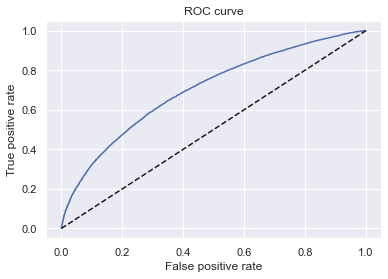

In [131]:
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

In [132]:
thresholds

array([1.99262865, 0.99262865, 0.99069771, ..., 0.48790773, 0.3937389 ,
       0.37528625])

In [133]:
thresholds.shape

(17263,)

In [134]:
df_cutoffs = pd.concat([pd.DataFrame(thresholds), pd.DataFrame(fpr), pd.DataFrame(tpr)], axis = 1)
# We concatenate 3 dataframes along the columns.

In [135]:
df_cutoffs.columns = ['thresholds', 'fpr', 'tpr']
# We name the columns of the dataframe 'thresholds', 'fpr', and 'tpr'.

In [136]:
df_cutoffs.head()

,thresholds,fpr,tpr
0,1.992629,0.000000,0.000000
1,0.992629,0.000000,0.000012
2,0.990698,0.000000,0.000120
3,0.990653,0.000098,0.000120
4,0.989823,0.000098,0.000421


In [137]:
df_cutoffs['thresholds'][0] = 1 - 1 / np.power(10, 16)
# Let the first threshold (the value of the thresholds column with index 0) be equal to a number, very close to 1
# but smaller than 1, say 1 - 1 / 10 ^ 16.

In [138]:
df_cutoffs['Score'] = ((np.log(df_cutoffs['thresholds'] / (1 - df_cutoffs['thresholds'])) - min_sum_coef) * ((max_score - min_score) / (max_sum_coef - min_sum_coef)) + min_score).round()
# The score corresponsing to each threshold equals:
# The the difference between the natural logarithm of the ratio of the threshold and 1 minus the threshold and
# the minimum sum of coefficients
# multiplied by
# the sum of the minimum score and the ratio of the difference between the maximum score and minimum score and 
# the difference between the maximum sum of coefficients and the minimum sum of coefficients.

In [139]:
df_cutoffs.head()

,thresholds,fpr,tpr,Score
0,1.000000,0.000000,0.000000,2066.0
1,0.992629,0.000000,0.000012,797.0
2,0.990698,0.000000,0.000120,779.0
3,0.990653,0.000098,0.000120,778.0
4,0.989823,0.000098,0.000421,772.0


In [140]:
df_cutoffs['Score'][0] = max_score

In [141]:
df_cutoffs.head()

,thresholds,fpr,tpr,Score
0,1.000000,0.000000,0.000000,850.0
1,0.992629,0.000000,0.000012,797.0
2,0.990698,0.000000,0.000120,779.0
3,0.990653,0.000098,0.000120,778.0
4,0.989823,0.000098,0.000421,772.0


In [142]:
df_cutoffs.tail()

,thresholds,fpr,tpr,Score
17258,0.493411,0.999411,0.999964,417.0
17259,0.488602,0.999607,0.999964,415.0
17260,0.487908,0.999607,0.999976,415.0
17261,0.393739,1.000000,0.999976,385.0
17262,0.375286,1.000000,1.000000,379.0


In [143]:
# We define a function called 'n_approved' which assigns a value of 1 if a predicted probability
# is greater than the parameter p, which is a threshold, and a value of 0, if it is not.
# Then it sums the column.
# Thus, if given any percentage values, the function will return
# the number of rows wih estimated probabilites greater than the threshold. 
def n_approved(p):
    return np.where(df_actual_predicted_probs['y_hat_test_proba'] >= p, 1, 0).sum()

In [144]:
df_cutoffs['N Approved'] = df_cutoffs['thresholds'].apply(n_approved)
# Assuming that all credit applications above a given probability of being 'good' will be approved,
# when we apply the 'n_approved' function to a threshold, it will return the number of approved applications.
# Thus, here we calculate the number of approved appliations for al thresholds.
df_cutoffs['N Rejected'] = df_actual_predicted_probs['y_hat_test_proba'].shape[0] - df_cutoffs['N Approved']
# Then, we calculate the number of rejected applications for each threshold.
# It is the difference between the total number of applications and the approved applications for that threshold.
df_cutoffs['Approval Rate'] = df_cutoffs['N Approved'] / df_actual_predicted_probs['y_hat_test_proba'].shape[0]
# Approval rate equalts the ratio of the approved applications and all applications.
df_cutoffs['Rejection Rate'] = 1 - df_cutoffs['Approval Rate']
# Rejection rate equals one minus approval rate.

In [145]:
df_cutoffs.head()

,thresholds,fpr,tpr,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
0,1.000000,0.000000,0.000000,850.0,0,93257,0.000000,1.000000
1,0.992629,0.000000,0.000012,797.0,1,93256,0.000011,0.999989
2,0.990698,0.000000,0.000120,779.0,10,93247,0.000107,0.999893
3,0.990653,0.000098,0.000120,778.0,11,93246,0.000118,0.999882
4,0.989823,0.000098,0.000421,772.0,36,93221,0.000386,0.999614


In [146]:
df_cutoffs.tail()

,thresholds,fpr,tpr,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
17258,0.493411,0.999411,0.999964,417.0,93248,9,0.999903,0.000097
17259,0.488602,0.999607,0.999964,415.0,93250,7,0.999925,0.000075
17260,0.487908,0.999607,0.999976,415.0,93251,6,0.999936,0.000064
17261,0.393739,1.000000,0.999976,385.0,93255,2,0.999979,0.000021
17262,0.375286,1.000000,1.000000,379.0,93257,0,1.000000,0.000000


In [147]:
df_cutoffs.iloc[5000: 6200, ]
# Here we display the dataframe with cutoffs form line with index 5000 to line with index 6200.

,thresholds,fpr,tpr,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
5000,0.903546,0.259568,0.547919,591.0,48159,45098,0.516412,0.483588
5001,0.903509,0.259568,0.548148,591.0,48178,45079,0.516615,0.483385
5002,0.903508,0.259666,0.548148,591.0,48179,45078,0.516626,0.483374
5003,0.903481,0.259666,0.548316,591.0,48193,45064,0.516776,0.483224
5004,0.903481,0.259764,0.548316,591.0,48194,45063,0.516787,0.483213
5005,0.903472,0.259764,0.548413,591.0,48202,45055,0.516873,0.483127
5006,0.903472,0.259863,0.548413,591.0,48203,45054,0.516883,0.483117
5007,0.903449,0.259863,0.548629,591.0,48221,45036,0.517076,0.482924
5008,0.903449,0.259961,0.548629,591.0,48222,45035,0.517087,0.482913
5009,0.903424,0.259961,0.548774,591.0,48234,45023,0.517216,0.482784


In [148]:
df_cutoffs.iloc[1000: 2000, ]
# Here we display the dataframe with cutoffs form line with index 1000 to line with index 2000.

,thresholds,fpr,tpr,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
1000,0.953241,0.049166,0.206592,651.0,17662,75595,0.189391,0.810609
1001,0.953230,0.049166,0.206737,651.0,17674,75583,0.189519,0.810481
1002,0.953226,0.049264,0.206737,651.0,17675,75582,0.189530,0.810470
1003,0.953219,0.049264,0.206809,651.0,17681,75576,0.189594,0.810406
1004,0.953219,0.049362,0.206809,651.0,17682,75575,0.189605,0.810395
1005,0.953192,0.049362,0.207026,651.0,17700,75557,0.189798,0.810202
1006,0.953190,0.049460,0.207026,651.0,17701,75556,0.189809,0.810191
1007,0.953187,0.049460,0.207050,651.0,17703,75554,0.189830,0.810170
1008,0.953184,0.049558,0.207050,651.0,17704,75553,0.189841,0.810159
1009,0.953143,0.049558,0.207278,651.0,17723,75534,0.190045,0.809955


In [149]:
inputs_train_with_ref_cat.to_csv('inputs_train_with_ref_cat.csv')

In [150]:
df_scorecard.to_csv('../Data/df_scorecard.csv')